In [1]:
import string
import re

import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Generate graphs in SVG format
%config InlineBackend.figure_format = 'svg'

# get reproducible results
np.random.seed(1997)
tf.random.set_seed(1997)

(Run only the first time)

In [2]:
# Windows-only
# !curl.exe -LOJ http://nlp.stanford.edu/data/glove.6B.zip

In [3]:
# !unzip glove.6B.zip

## Load data

In [4]:
df = pd.read_csv('data/presidential_speeches_cleaned.csv', encoding='utf-8', usecols=['Party', 'Cleaned'])
df.sample(5)

,Party,Cleaned
421,Democratic,fellow americans washington birthday appropria...
373,Republican,members american bankers association guests gl...
648,Republican,officers ladies gentlemen national press club ...
256,Republican,senate house representatives notwithstanding a...
615,Republican,chairman delegates alternates republican conve...


In [5]:
df['Party'].value_counts()

Democratic    489
Republican    389
Name: Party, dtype: int64

In [6]:
enc = LabelEncoder()
enc.fit(df['Party'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_)))
df['Party'] = enc.fit_transform(df['Party'])
encoded_labels

{'Democratic': 0, 'Republican': 1}

In [7]:
X = df.drop('Party', axis=1)
y = df['Party']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=97, stratify=y)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(702, 1) (702,)
(176, 1) (176,)


## Preprocessing

In [8]:
def clean(input_data):
    text = tf.strings.lower(input_data)
    text = tf.strings.regex_replace(
        text, f'[{re.escape(string.punctuation)}]', '' # remove punctuation
    )
    return text

# Constants for the models
embedding_dim = 128
max_len = 512

tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")

tokenizer.fit_on_texts(X_train['Cleaned'])
train_df = tokenizer.texts_to_sequences(X_train['Cleaned'])
test_df = tokenizer.texts_to_sequences(X_val['Cleaned'])

# Pad sequences less than `max_len` with zeros
train_df = keras.preprocessing.sequence.pad_sequences(train_df, maxlen=max_len, padding='post')
test_df = keras.preprocessing.sequence.pad_sequences(test_df, maxlen=max_len, padding='post')

In [9]:
train_df[:5]

array([[ 371, 2181,  371, ...,  173,  343, 1309],
       [  81,  793,   91, ...,   98, 1041,    7],
       [9442,    4, 2590, ...,  259, 4137,    9],
       [1139,  244,  181, ..., 3889,    1,    1],
       [ 978, 1044,   54, ...,    1, 1944,   27]])

In [10]:
test_df[:5]

array([[  18,    5,    2, ...,    0,    0,    0],
       [  18, 1344, 1101, ...,    0,    0,    0],
       [2557, 3195, 6774, ...,  158, 1309,   25],
       [  63,  444,   31, ..., 1099,    1, 7954],
       [2695,  134,  328, ..., 6178,  153, 4767]])

In [11]:
vocab_len = len(tokenizer.word_index) + 1 # +1 for the out-of-vocabulary token

## Setup embeddings

In [12]:
from typing import Literal
DIMS = Literal[50, 100, 200, 300] # type alias for the dimensions

def get_embbeddings(dim: DIMS = 50):
    embed = {}
    with open(f'glove.6B.{dim}d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            word, *coefs = line.split() # splat operator (*) to unpack all but the first element, see: https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists
            coefs = np.asarray(coefs, dtype='float32')
            embed[word] = coefs
    print(f"Found {len(embed)} vectors")
    return embed

In [13]:
word2embed_example = get_embbeddings()
list(word2embed_example.keys())[:10]

Found 400000 vectors


['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [14]:
word2embed_example['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [15]:
def build_embed_matrix(dim=50):
    word2embed = get_embbeddings(dim=dim)
    
    embedding_matrix = np.zeros((vocab_len, dim))
    
    counter = 0
    
    for word, index in tokenizer.word_index.items():
        embedding_vector = word2embed.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            counter += 1

    return embedding_matrix

In [16]:
embedding_matrix_example = build_embed_matrix(50)

Found 400000 vectors


In [17]:
embedding_matrix_example.shape

(32625, 50)

In [18]:
def plot_graphs(history, metric: str):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train', 'val'])
    plt.title(f"{metric.capitalize()} for {history.model.name}")

## CNN

In [19]:
keras.backend.clear_session()
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
embedding_matrix = build_embed_matrix(300)

model = keras.Sequential(name='CNN')
model.add(keras.layers.Input(shape=(max_len,)))
model.add(keras.layers.Embedding(vocab_len, 300, weights=[embedding_matrix]))

# Add convolutional layers and dropout to reduce overfitting
model.add(keras.layers.Conv1D(128, 5, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Conv1D(64, 4, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
model.add(keras.layers.Dropout(0.5))

# Add max pooling layer to get the max value in each filter
model.add(keras.layers.GlobalMaxPooling1D())

model.add(keras.layers.Dense(1, activation='sigmoid', name='output'))
model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    train_df, 
    y_train, 
    epochs=50, 
    validation_data=(test_df, y_val), 
    callbacks=[early_stopping], 
    batch_size=128
)

Found 400000 vectors
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 300)          9787500   
                                                                 
 conv1d (Conv1D)             (None, 508, 128)          192128    
                                                                 
 dropout (Dropout)           (None, 508, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 505, 64)           32832     
                                                                 
 dropout_1 (Dropout)         (None, 505, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 503, 32)           6176      
                                                                 
 dropout_2 (Dropout)         (None, 503, 3

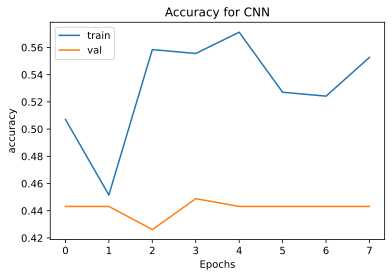

In [20]:
plot_graphs(history, 'accuracy')

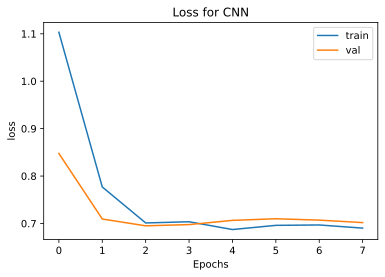

In [21]:
plot_graphs(history, 'loss')

## LSTM

In [57]:
keras.backend.clear_session()
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
embedding_matrix = build_embed_matrix(dim=300)

model = keras.Sequential(name='LSTM')
model.add(keras.layers.Input(shape=(max_len,)))
model.add(keras.layers.Embedding(vocab_len, 300, weights=[embedding_matrix]))
model.add(keras.layers.LSTM(300, return_sequences=True))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.003)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    train_df, 
    y_train, 
    epochs=50, 
    validation_data=(test_df, y_val), 
    callbacks=[early_stopping], 
    batch_size=128
)

Found 400000 vectors
Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 300)          9787500   
                                                                 
 lstm (LSTM)                 (None, 512, 300)          721200    
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 1)                 153601    
                                                                 
Total params: 10,662,301
Trainable params: 10,662,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
6/6 [==============================] - 104s 17s/step - loss: 5.0404 - accuracy: 0.5000 - val_loss: 0.8063 - val_accuracy: 0.4943
Epoch 2/50
6/6 [=====

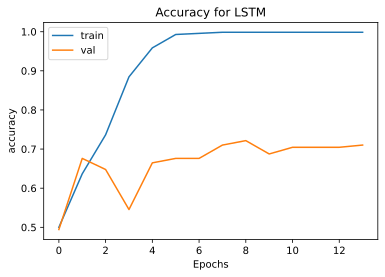

In [58]:
plot_graphs(history, 'accuracy')

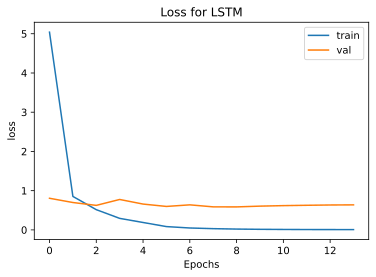

In [59]:
plot_graphs(history, 'loss')